## BC Raw Log Exports

Data taken from [Forest - BC Govt](https://www2.gov.bc.ca/gov/content/data/statistics/business-industry-trade/industry/forestry) and [OECD CPI](https://data.oecd.org/price/inflation-cpi.htm)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
raw_data = pd.read_csv("raw_data/BCLogExports_MinFor_180112.csv",header=1,thousands=",").dropna(how='any')
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7735 entries, 0 to 7734
Data columns (total 6 columns):
Year                   7735 non-null object
Month                  7735 non-null object
Commodity              7735 non-null object
Destination Country    7735 non-null object
Value - Cdn $          7735 non-null float64
Quantity - m3          7735 non-null float64
dtypes: float64(2), object(4)
memory usage: 423.0+ KB


In [3]:
raw_data.columns = ["Year","Month","Commodity",'Destination','Value','Quantity']

In [4]:
dfMonths = pd.DataFrame({'Month':['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December'],'MonthIndex':range(12)})
data = pd.merge(raw_data,dfMonths,on="Month")
data['Year'] = data['Year'].apply(int)

In [5]:
aggregated = data.groupby(['Year','Destination'])['Value','Quantity'].mean() * 12
totals = aggregated.reset_index().groupby(['Year']).sum()

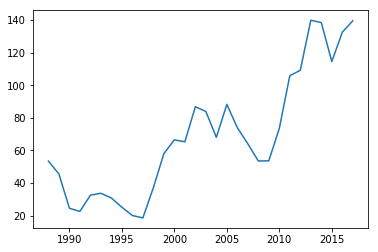

In [6]:
plt.plot(totals['Value']/1000000)

In [7]:
annual_pivot = aggregated.reset_index().pivot(index="Year",columns="Destination",values="Value").fillna(0)
annual_pivot.columns

Index(['Albania', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Belgium', 'Bermuda', 'Czech Republic', 'Denmark',
       'Finland', 'France', 'French Polynesia', 'Germany', 'Greece',
       'Guatemala', 'Hong Kong', 'Iceland', 'India', 'Indonesia', 'Ireland',
       'Israel', 'Italy', 'Japan', 'Jordan', 'Kazakhstan', 'Kuwait', 'Laos',
       'Latvia', 'Lebanon', 'Mainland China', 'Malaysia', 'Mexico',
       'Netherlands', 'New Zealand', 'North Korea', 'Pakistan', 'Peru',
       'Philippines', 'Russia', 'Saudi Arabia', 'Singapore', 'South Africa',
       'South Korea', 'Spain', 'St Pierre-Miquelin', 'Sweden', 'Switzerland',
       'Taiwan', 'Thailand', 'Turkey', 'United Arab Emirates',
       'United Kingdom', 'United States', 'Vietnam'],
      dtype='object', name='Destination')

In [8]:
dfAgg = aggregated.reset_index()

In [9]:
total_value = totals['Value']

In [10]:
def country_stats(annual_pivot,country,totalValue):
    cValue = annual_pivot[country]
    fraction = cValue / total_value
    return fraction

In [11]:
per_country = {}
for c in ['Japan','United States','Mainland China']:
    per_country[c] = country_stats(annual_pivot,c,total_value)

In [12]:
dfFracs = pd.DataFrame(per_country)
dfFracs['Rest of World'] = 1 - dfFracs.apply(np.sum,axis=1)

Text(0.5,0.98,'Export destination as fraction of total export value')

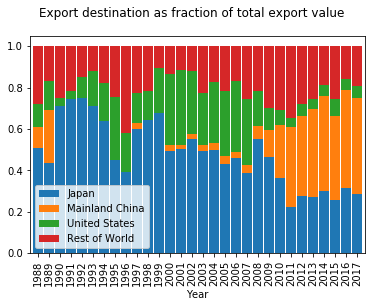

In [13]:
dfFracs.plot(kind="bar",stacked=True, width =0.9)
plt.suptitle("Export destination as fraction of total export value", fontsize=12)

In [14]:
dfValues = pd.DataFrame(per_country)
for c in per_country.keys():
    dfValues[c] = dfValues[c] * total_value
dfValues['Rest of World'] = total_value - dfValues.apply(np.sum,axis=1)

Text(0.5,0.98,'Export destination export values')

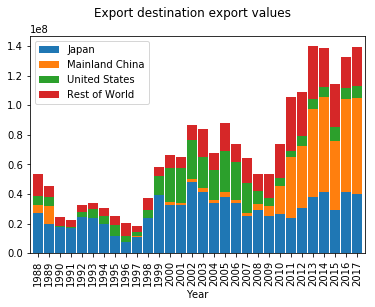

In [15]:
dfValues.plot(kind="bar",stacked=True, width =0.9)
plt.suptitle("Export destination export values", fontsize=12)

## Inflation adjustment

Using OECD CPI data

In [16]:
raw_cpi = pd.read_csv("raw_data/oecd_inflation_20180117.csv",header=0,thousands=",")#.dropna(how='any')

In [17]:
raw_cpi['Year'] = raw_cpi['TIME'].apply(lambda x:x[:4]).apply(int)
raw_cpi['Month'] = raw_cpi['TIME'].apply(lambda x:x[5:]).apply(int)
raw_cpi['PerMonthFactor'] = 1+(raw_cpi['Value'] * (0.01/12))
cpi_indexation = raw_cpi.groupby(['LOCATION','Year'])['PerMonthFactor'].prod().reset_index()

In [18]:
annual_indexation_factors = cpi_indexation.pivot(index="Year",columns="LOCATION",values="PerMonthFactor")
annual_index = annual_indexation_factors.apply(np.cumprod,axis=0)

In [19]:
canada_rpi = annual_index['CAN']
# Rebase to 2017 values; this conveniently skips over the partial year nature of 2017
canada_rpi /= canada_rpi[2017]

In [20]:
dfInfAdjValues = pd.DataFrame(per_country)
for c in per_country.keys():
    dfInfAdjValues[c] = dfInfAdjValues[c] * total_value / canada_rpi
dfInfAdjValues['Rest of World'] = total_value/canada_rpi - dfValues.apply(np.sum,axis=1)

Text(0.5,0.98,'Export destination export values, inflation rebased to 2017')

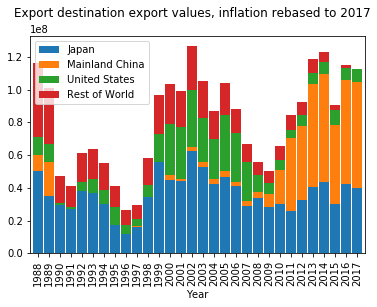

In [21]:
dfInfAdjValues.plot(kind="bar",stacked=True, width =0.9)
plt.suptitle("Export destination export values, inflation rebased to 2017", fontsize=12)

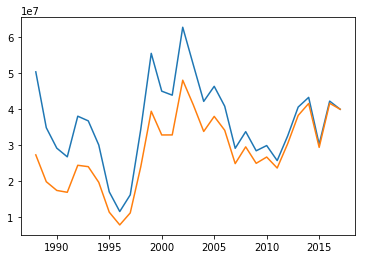

In [22]:
plt.plot(dfInfAdjValues['Japan'])
plt.plot(dfValues['Japan'])


Text(0.5,0.98,'Export destination trailing 5y average export values, inflation rebased to 2017')

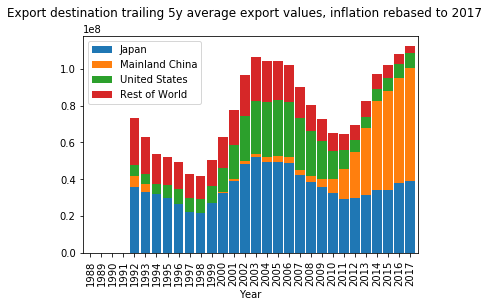

In [23]:
dfInfAdjValues.rolling(window=5).mean().plot(kind="bar",stacked=True, width =0.9)
plt.suptitle("Export destination trailing 5y average export values, inflation rebased to 2017", fontsize=12)